In [ ]:
#!pip install pooch
#!conda install pooch

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client
import warnings
import time
import glob
import seaborn as sns

warnings.filterwarnings("ignore")

In [ ]:
ds = xr.tutorial.load_dataset("air_temperature")

In [ ]:
ds.air.isel(time=0).plot()

In [ ]:
air_array = ds.air.data

In [ ]:
da = xr.DataArray(air_array,dims=('lat','time','lon'))


In [ ]:
lon_value = np.arange(200,331,2.5)
da = xr.DataArray(air_array,dims=('time','lat','lon'),coords={'lon':lon_value})
da

In [ ]:
da.coords['lat']=np.arange(75,14.9,-2.5)

In [ ]:
#da.attrs['Name'] = 'Sample_Tutorial'

In [ ]:
#reindex the values

data1 = xr.Dataset({
    'pm2p5': (['x', 'y','z'], np.arange(8).reshape(4,2,1)),
    }, coords={
    'x': [10.01, 10.02, 10.03, 10.04],
    'y': [20.01, 20.02],
    'z':['time1'],
})

data2 = xr.Dataset({
    'pm2p5': (['x', 'y','z'], np.array([10,0,20,0,30,0,40,50]).reshape(4,2,1)),
    }, coords={
    'x': [10.01, 10.02, 10.03, 10.04],
    'y': [20.01, 20.02],
    'z':['time2'],
})

data1 = data1.where(data1['pm2p5'] != 0, np.nan)
data2 = data2.where(data2['pm2p5'] != 0, np.nan)


data1.to_dataframe()

## REINDEXING

In [ ]:
data1 = data1.reindex(y=data1.y[::-1])
data1.to_dataframe()

In [ ]:
data2.to_dataframe()

In [ ]:
ds = xr.concat([data1,data2],dim='z')
print(np.isnan(ds['pm2p5']).sum())

In [ ]:
ds.to_dataframe()

## COARSEN

In [ ]:
regrid_ds = ds.coarsen(x=2,y=2,boundary='pad').mean()
#regrid_ds['x'] = ds['x'].data[::2]
#regrid_ds['x'] = ds['x'].data[::2]
#regrid_ds['y'] = ds['y'].data[::3]
#regrid_ds['y'] = regrid_ds['y'].values[::factor]
regrid_ds.to_dataframe()

## Plotting function

In [ ]:
def plotting(data,lat,lon):
    print(lat,lon)
    fig, ax = plt.subplots()
    p = data.pm2p5.plot.pcolormesh(y='lon_bins', x='lat')
    for i in range(len(lat)):
        for j in range(len(lon)):
            ax.annotate(str(round(float(data['pm2p5'][i,j].values), 2)), 
                        xy=(lon[j], lat[i]), 
                        color='black', ha='center', va='center')
    plt.xticks(lon)
    plt.yticks(lat)
    plt.show()

In [185]:
#Loading AOD Dataset for testing 
aod_file = glob.glob('./Data/AOD/*')
aod_insat3D = glob.glob(aod_file[0]+'/*')
aod_insat3DR = glob.glob(aod_file[1]+'/*')
ds_3DR = xr.open_mfdataset(aod_insat3DR)
ds_3D = xr.open_mfdataset(aod_insat3D)

#slicing
ds1_3DR = ds_3DR.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99))
ds1_3D = ds_3D.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99))

#merging
ds_merged = xr.concat([ds1_3DR, ds1_3D], dim='time').sortby('time')

In [186]:
ds_merged1 = ds_merged.where(ds_merged.AOD > 0)
ds_merged1

<xarray.Dataset>
Dimensions:    (time: 4475, latitude: 310, longitude: 320)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
  * time       (time) datetime64[ns] 2018-01-01T05:15:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 dask.array<chunksize=(1, 310, 320), meta=np.ndarray>
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [189]:
ds_merged2 = ds_merged1.reindex(latitude=ds_merged1.latitude[::-1])
ds_merged2

<xarray.Dataset>
Dimensions:    (latitude: 310, longitude: 320, time: 4475)
Coordinates:
  * latitude   (latitude) float64 8.05 8.15 8.25 8.35 ... 38.75 38.85 38.95
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
  * time       (time) datetime64[ns] 2018-01-01T05:15:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 dask.array<chunksize=(1, 310, 320), meta=np.ndarray>
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [ ]:
out_res = float(0.25)

#half of orginal resolution
interval_window = out_res/2 
new_lat = np.arange(8-interval_window, 38 + out_res, out_res) # Latitude label i.e 8,..,38
new_lon = np.arange(68-interval_window, 98 + out_res, out_res) # longitude Label i.e 68,..,98


ds_merged3 = ds_merged2.groupby_bins("longitude", bins=new_lon).mean(dim="longitude").groupby_bins("latitude", bins=new_lat).mean(dim="latitude")

#Renaming longitude and latitude coordinate
ds_merged3 = ds_merged3.rename({"longitude_bins":"longitude","latitude_bins":"latitude"})

ds_merged3['latitude'] = new_lat[:-1] + interval_window
ds_merged3['longitude'] = new_lon[:-1] + interval_window

ds_merged3

## Sample data

In [182]:
# Create sample data

res = 0.01 # input resolution
start_lat = 0
end_lat = 0.25

start_lon = 0
end_lon = 0.25

#time = pd.date_range('2018',periods=3,freq='M')
lat = np.arange(start_lat,end_lat+res,res) 
lon = np.arange(start_lon,end_lon+res,res)



#t = len(time)
m = len(lat)
n = len(lon)
data = np.round(np.random.rand(m,n),1)

#Randomly assign NaN value to data
for i in range(np.random.randint(0,256)):
    data[np.random.randint(0,m),np.random.randint(0,n)] = np.nan

data_set = xr.Dataset({"pm2p5": (["lat","lon"],data)},
                 coords={"lat": lat,"lon":lon})

#plotting
# fig, ax = plt.subplots()
# p = data_set.pm2p5.plot.pcolormesh(x='lon', y='lat')
# for i in range(len(lat)):
#     for j in range(len(lon)):
#         ax.annotate(str(data_set['pm2p5'][i,j].values), 
#                     xy=(lon[j], lat[i]), 
#                     color='black', ha='center', va='center')
# plt.xticks(lon,rotation = 45)
# plt.yticks(lat)
# plt.show()


# group_bin

In [181]:
#output resolution
out_res = 0.05

#half of orginal resolution
interval_window = out_res/2 
new_lat = np.arange(lat[0]-interval_window, lat[-1]+out_res, out_res) # Latitude label
new_lon = np.arange(lon[0]-interval_window, lon[-1]+out_res, out_res) # longitude Label


#gb = data_set.groupby_bins("lon", bins=new_lon).mean(dim="lon").groupby_bins("lat", bins=new_lat).mean(dim="lat")
#count_nan_gb = ds3.groupby_bins("longitude", bins=new_lon).apply(lambda x: x.groupby_bins("latitude", bins=new_lat).apply(lambda y: y.isnull().sum()))

# gb = data_set.groupby_bins( "lat", bins=new_lat).apply(lambda x: x.groupby_bins("lon", bins=new_lon).apply(lambda y: y.mean().where(y.isnull().sum()<1, np.nan) ))

print(new_lat,new_lon)



gb = data_set.groupby_bins( "lat", bins=new_lat).apply(lambda x: x.groupby_bins("lon", bins=new_lon).apply(lambda y: y.isnull().sum() + y.count() ))
 

#print(gb.to_dataframe())
x = np.arange(15,70,5) # percentage of data point required for mean
y= np.array([]) # avg pm2p5

for i in range(len(x)):
    #Take mean if no of data points are atleast 2
    thres_value = x[i]/100
    gb1 = data_set.groupby_bins( "lat", bins=new_lat).apply(lambda x: x.groupby_bins("lon", bins=new_lon).apply(lambda y: y.mean().where(y.count()>= thres_value*(y.isnull().sum() + y.count()), np.nan) ))
    y = np.append(y,gb1.pm2p5.mean().data)

#plotting
gb['lat_bins'] = new_lat[:-1] + interval_window
gb['lon_bins'] = new_lon[:-1] + interval_window

# fig, ax = plt.subplots()
# p = gb.pm2p5.plot.pcolormesh(x='lon_bins', y='lat_bins')
# for i in range(len(gb.lat_bins.data)):
#     for j in range(len(gb.lon_bins.data)):
#         ax.annotate(str(round(float(gb['pm2p5'][i,j].values), 3)), 
#                     xy=(gb.lon_bins[j], gb.lat_bins[i]), 
#                     color='black', ha='center', va='center')
# plt.xticks(gb.lon_bins.data)
# plt.yticks(gb.lat_bins.data)
# plt.show()

# print(new_lat)
# print(new_lon)

[-0.025  0.025  0.075  0.125  0.175  0.225  0.275] [-0.025  0.025  0.075  0.125  0.175  0.225  0.275]


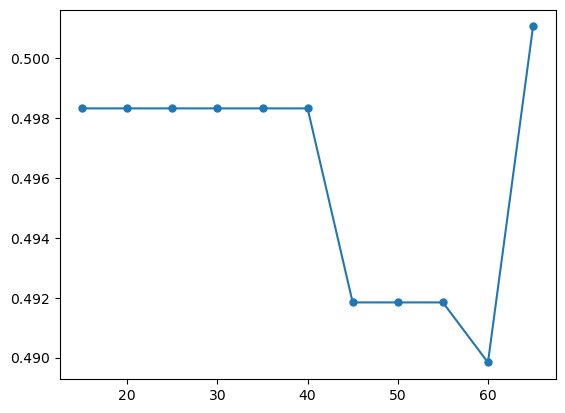

In [179]:
plt.plot(x, y, marker = '.', markersize = 10)
plt.show()

## Sample test with time dimension

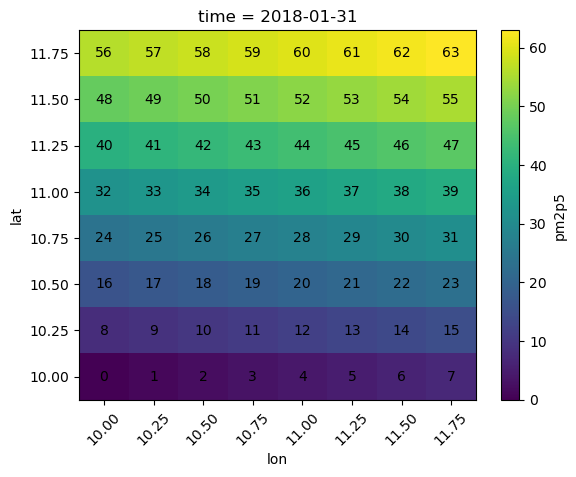

time  pm2p5
lat   lon                    
10.00 10.00 2018-01-31      0
      10.25 2018-01-31      1
      10.50 2018-01-31      2
      10.75 2018-01-31      3
      11.00 2018-01-31      4
...                ...    ...
11.75 10.75 2018-01-31     59
      11.00 2018-01-31     60
      11.25 2018-01-31     61
      11.50 2018-01-31     62
      11.75 2018-01-31     63

[64 rows x 2 columns]

In [44]:
#sample test
res = 0.25
time = pd.date_range('2018',periods=3,freq='M')
lat = np.arange(10,12,res) 
lon = np.arange(10,12,res)

t = len(time)
m = len(lat)
n = len(lon)
data = np.arange(t*m*n).reshape(t,m,n)
data_set = xr.Dataset({"pm2p5": (["time","lat","lon"],data)},
                 coords={"time":time,"lat": lat,"lon":lon})

fig, ax = plt.subplots()
p = data_set.pm2p5.isel(time=0).plot.pcolormesh(x='lon', y='lat')
for i in range(len(lat)):
    for j in range(len(lon)):
        ax.annotate(str(data_set['pm2p5'][0,i,j].values), 
                    xy=(lon[j], lat[i]), 
                    color='black', ha='center', va='center')
plt.xticks(lon,rotation = 45)
plt.yticks(lat)
plt.show()
data_set.pm2p5.isel(time=0).to_dataframe()

In [ ]:
out_res = 0.5

#half of orginal resolution
interval_window = out_res/2 
new_lat = np.arange(lat[0]-interval_window, lat[-1]+out_res, out_res) # Latitude label
new_lon = np.arange(lon[0]-interval_window, lon[-1]+out_res, out_res) # longitude Label


gb = data_set.groupby_bins("lon", bins=new_lon).mean(dim="lon").groupby_bins("lat", bins=new_lat).mean(dim="lat")

#print(gb.to_dataframe())
#plotting
gb['lat_bins'] = new_lat[:-1] + interval_window
gb['lon_bins'] = new_lon[:-1] + interval_window

fig, ax = plt.subplots()
p = gb.pm2p5.isel(time=0).plot.pcolormesh(x='lon_bins', y='lat_bins')
for i in range(len(gb.lat_bins.data)):
    for j in range(len(gb.lon_bins.data)):
        ax.annotate(str(round(float(gb['pm2p5'].isel(time=0)[i,j].values), 3)), 
                    xy=(gb.lon_bins[j], gb.lat_bins[i]), 
                    color='black', ha='center', va='center')
plt.xticks(gb.lon_bins.data)
plt.yticks(gb.lat_bins.data)
plt.show()


gb.pm2p5.isel(time=0).to_dataframe()

# Regridding using CDO

In [ ]:
#!pip install nctoolkit
#!pip install numpy 

In [ ]:
import nctoolkit as nc
import numpy as np

In [ ]:
import harp

latitudes = np.arange(1,2,0.01)
longitudes = np.arange(1,2,0.01)
#time = np.arange('2022-01-01', '2022-01-02', np.timedelta64(1, 'h'))


# Grouping all hourly data into montly data

In [ ]:
#sample hourly data

time = pd.date_range(start='2018-01',periods=4,freq='17D')
lat = np.arange(1,3) 
lon = np.arange(1,3)
t = len(time)
m = len(lat)
n = len(lon)
data = np.round(np.random.rand(t,m,n),1)
ds = xr.Dataset({"pm2p5": (["time","lat","lon"],data)},
                 coords={"time":time, "lat": lat,"lon":lon})
ds.to_dataframe()

In [ ]:
ds = ds.resample(time = "1M").mean()
ds.to_dataframe()

In [ ]:
ds1 = ds.groupby('time.month').mean('time')
ds1.to_dataframe()

# Reading Dask array using Xarray 

In [ ]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

In [2]:
aod_dir = glob.glob('./Data/INSAT3DR_AOD/*')

ds = xr.open_mfdataset(aod_dir)

In [3]:
ds1 = ds.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99))
ds1.time[:25]

<xarray.DataArray 'time' (time: 25)>
array(['2018-01-01T05:15:00.000000000', '2018-01-01T05:45:00.000000000',
       '2018-01-01T07:45:00.000000000', '2018-01-01T08:15:00.000000000',
       '2018-01-02T05:15:00.000000000', '2018-01-02T05:45:00.000000000',
       '2018-01-02T06:15:00.000000000', '2018-01-02T06:45:00.000000000',
       '2018-01-02T07:15:00.000000000', '2018-01-02T07:45:00.000000000',
       '2018-01-02T08:15:00.000000000', '2018-01-03T05:15:00.000000000',
       '2018-01-03T05:45:00.000000000', '2018-01-03T06:15:00.000000000',
       '2018-01-03T06:45:00.000000000', '2018-01-03T07:15:00.000000000',
       '2018-01-03T07:45:00.000000000', '2018-01-04T05:15:00.000000000',
       '2018-01-04T05:45:00.000000000', '2018-01-04T06:15:00.000000000',
       '2018-01-04T07:15:00.000000000', '2018-01-04T07:45:00.000000000',
       '2018-01-05T05:15:00.000000000', '2018-01-05T05:45:00.000000000',
       '2018-01-05T06:45:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T05:15:00 ... 2018-01-05T06:45:00

In [4]:
aod_da = ds1.AOD.load()

In [5]:
aod_da.min().load()

<xarray.DataArray 'AOD' ()>
array(-0.05990245)

In [6]:
ds2 = ds1.sortby('time')
#monthly_data = ds2.AOD.resample(time='M').mean('time')

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 5))
# monthly_data.plot.hist(ax=ax)
# plt.show()


In [ ]:
# df = monthly_data.to_dataframe().reset_index()

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.boxplot(x='time', y='AOD', data=df, ax=ax)
# plt.show()

In [7]:
ds1.time[:25]

<xarray.DataArray 'time' (time: 25)>
array(['2018-01-01T05:15:00.000000000', '2018-01-01T05:45:00.000000000',
       '2018-01-01T07:45:00.000000000', '2018-01-01T08:15:00.000000000',
       '2018-01-02T05:15:00.000000000', '2018-01-02T05:45:00.000000000',
       '2018-01-02T06:15:00.000000000', '2018-01-02T06:45:00.000000000',
       '2018-01-02T07:15:00.000000000', '2018-01-02T07:45:00.000000000',
       '2018-01-02T08:15:00.000000000', '2018-01-03T05:15:00.000000000',
       '2018-01-03T05:45:00.000000000', '2018-01-03T06:15:00.000000000',
       '2018-01-03T06:45:00.000000000', '2018-01-03T07:15:00.000000000',
       '2018-01-03T07:45:00.000000000', '2018-01-04T05:15:00.000000000',
       '2018-01-04T05:45:00.000000000', '2018-01-04T06:15:00.000000000',
       '2018-01-04T07:15:00.000000000', '2018-01-04T07:45:00.000000000',
       '2018-01-05T05:15:00.000000000', '2018-01-05T05:45:00.000000000',
       '2018-01-05T06:45:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T05:15:00 ... 2018-01-05T06:45:00

In [26]:
ds2 = ds1.time.dt.floor("D")

In [40]:
ds2.sel(time=slice('2018-10-11','2018-10-12'))

<xarray.DataArray 'floor' (time: 26)>
array(['2018-10-11T00:00:00.000000000', '2018-10-11T00:00:00.000000000',
       '2018-10-11T00:00:00.000000000', '2018-10-11T00:00:00.000000000',
       '2018-10-11T00:00:00.000000000', '2018-10-11T00:00:00.000000000',
       '2018-10-11T00:00:00.000000000', '2018-10-11T00:00:00.000000000',
       '2018-10-11T00:00:00.000000000', '2018-10-11T00:00:00.000000000',
       '2018-10-11T00:00:00.000000000', '2018-10-11T00:00:00.000000000',
       '2018-10-11T00:00:00.000000000', '2018-10-12T00:00:00.000000000',
       '2018-10-12T00:00:00.000000000', '2018-10-12T00:00:00.000000000',
       '2018-10-12T00:00:00.000000000', '2018-10-12T00:00:00.000000000',
       '2018-10-12T00:00:00.000000000', '2018-10-12T00:00:00.000000000',
       '2018-10-12T00:00:00.000000000', '2018-10-12T00:00:00.000000000',
       '2018-10-12T00:00:00.000000000', '2018-10-12T00:00:00.000000000',
       '2018-10-12T00:00:00.000000000', '2018-10-12T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-10-11T05:15:00 ... 2018-10-12T08:15:00

In [31]:
ds2.time.data.shape

(2368,)

In [32]:
df = pd.DataFrame(ds2, columns=['TIME'])

In [38]:
df.TIME.value_counts()

2018-10-11    13
2018-11-13    13
2018-10-12    13
2018-10-10    13
2018-11-15    13
              ..
2018-06-04     3
2018-01-16     2
2018-02-16     2
2018-02-09     2
2018-03-14     1
Name: TIME, Length: 359, dtype: int64

In [37]:
df.TIME.value_counts().min()

1